In [2]:
import sys
sys.path.append("..")

from pathlib import Path
import pandas as pd
import nibabel as nib

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance

from bold_dementia.data.memento import Memento
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices

BIDSDIR = Path("/georges/memento/BIDS")
PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")
ATLAS = "msdl"
confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}

phenotypes = Memento.load_phenotypes(PPATH)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
no_dementia_mask = phenotypes.days_to_onset.isna()
controls = phenotypes[no_dementia_mask].sample(n=20, random_state=1234)
AD_mask = ((phenotypes.MA == 1))
demented = phenotypes[AD_mask].sample(20, random_state=1234)
subjects = pd.concat([demented, controls])

In [4]:
from nilearn.interfaces.bids import get_bids_files, parse_bids_filename
fmri_path = get_bids_files(
    BIDSDIR / "derivatives/fmriprep-23.2.0",
    "bold",
    modality_folder="func",
    file_type="nii.gz",
    filters=[
    #    #("space", "MNI152NLin2009cAsym")
        ("space", "MNI152NLin6Asym"),
        ("ses", "M000")
    ],
)

In [5]:
# TODO SCAN TO ONSET!!!
df = pd.DataFrame(map(parse_bids_filename, fmri_path))

rest_dataset = pd.merge(
    left=df,
    right=subjects,
    how="left",
    on="sub"
)
rest_dataset = rest_dataset.dropna(axis=0, subset="CEN_ANOM")
rest_dataset.sample(n=4)

,file_path,file_basename,file_tag,file_type,file_fields,sub,ses,task,space,res,...,DEMENCE_DAT,APOE_eps4,APOE_geno,APOE_y,M000,M024,M048,declared_dementia,age_of_onset,days_to_onset
274,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0625_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0625,M000,rest,MNI152NLin6Asym,2,...,2015-03-24,1.0,eps3/eps4,Oui,2014-03-27,NaT,NaT,True,77.391781,362.0
334,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-0775_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",0775,M000,rest,MNI152NLin6Asym,2,...,NaT,0.0,eps3/eps3,Non,2013-06-26,2015-08-27,NaT,False,NaN,NaN
1105,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-2213_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",2213,M000,rest,MNI152NLin6Asym,2,...,NaT,0.0,eps2/eps3,Non,2012-11-22,2015-05-29,2017-02-24,False,NaN,NaN
849,/georges/memento/BIDS/derivatives/fmriprep-23....,sub-1770_ses-M000_task-rest_space-MNI152NLin6A...,bold,nii.gz,"[sub, ses, task, space, res, desc]",1770,M000,rest,MNI152NLin6Asym,2,...,2017-10-17,0.0,eps3/eps3,Non,2012-12-20,2014-12-18,2016-11-16,True,82.193151,1859.0


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(


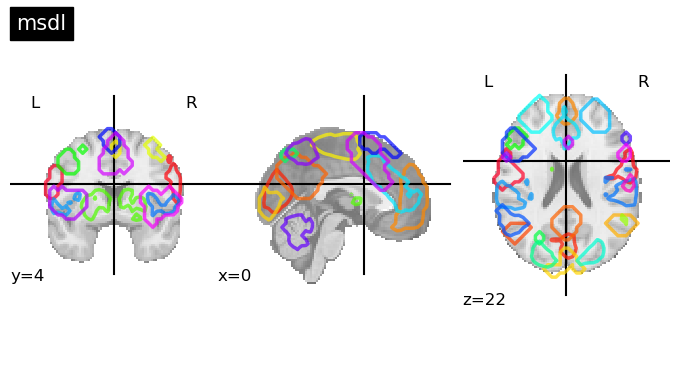

In [5]:
atlas = Atlas.from_name(ATLAS, soft=True)
atlas.plot()

In [6]:

masker = atlas.fit_masker()
control_ts = []
AD_ts = []
for index, subrow in rest_dataset.iterrows():
    # Preloading with nib is faster than passing a string path
    # to nilearn
    img = nib.load(subrow.file_path)
    confounds, sample_mask = load_confounds(
        subrow.file_path,
        **confounds_strategy
    )
    ts = masker.transform(img, confounds, sample_mask)
    if subrow.declared_dementia:
        AD_ts.append(ts)
    else:
        control_ts.append(ts)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:349: FutureWarning: The de

In [7]:
AD_gsc = GroupSparseCovariance()
control_gsc = GroupSparseCovariance()
sc = StandardScaler() # Could be refactored in a more elegant way but whatever
AD_gsc.fit([sc.fit_transform(ts) for ts in AD_ts])
control_gsc.fit([sc.fit_transform(ts) for ts in control_ts])

GroupSparseCovariance()

In [36]:

import matplotlib.pyplot as plt
def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing."""
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    #span = max(abs(prec.min()), abs(prec.max()))
    span = 1

    # Display covariance matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    plotting.plot_matrix(
        cov,
        cmap=plotting.cm.bwr,
        vmin=-1,
        vmax=1,
        title=f"{title} / covariance",
        labels=labels,
        axes=ax1
    )
    # Display precision matrix
    plotting.plot_matrix(
        prec,
        cmap=plotting.cm.bwr,
        vmin=-span,
        vmax=span,
        title=f"{title} / precision",
        labels=labels,
        axes=ax2
    )

    return fig

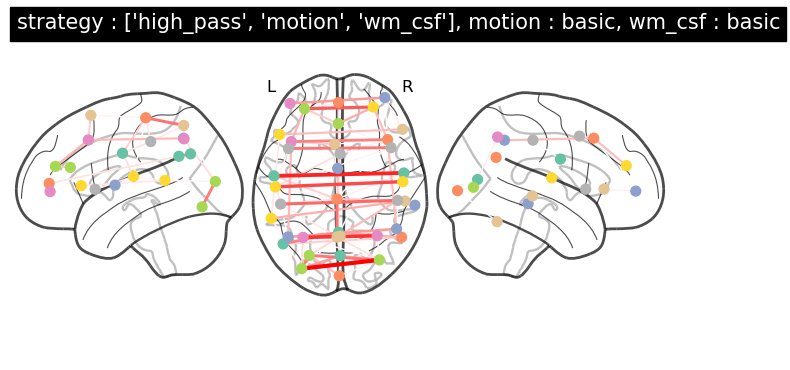

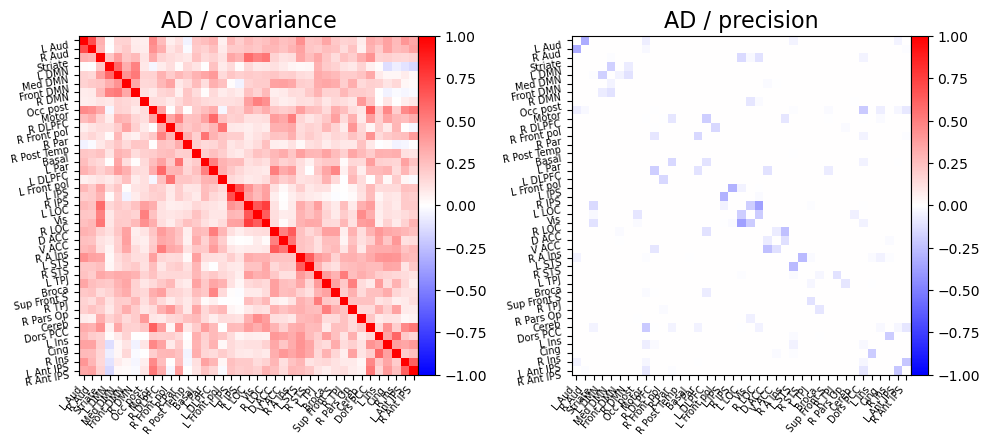

In [37]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

plotting.plot_connectome(
    -AD_gsc.precisions_.mean(axis=2),
    atlas.get_coords(),
    edge_threshold="90%",
    title=title,
    display_mode="lzr",
)
# Mean ou pas mean?
plot_matrices(AD_gsc.covariances_.mean(axis=2), AD_gsc.precisions_.mean(axis=2), "AD", atlas.labels)

plotting.show()

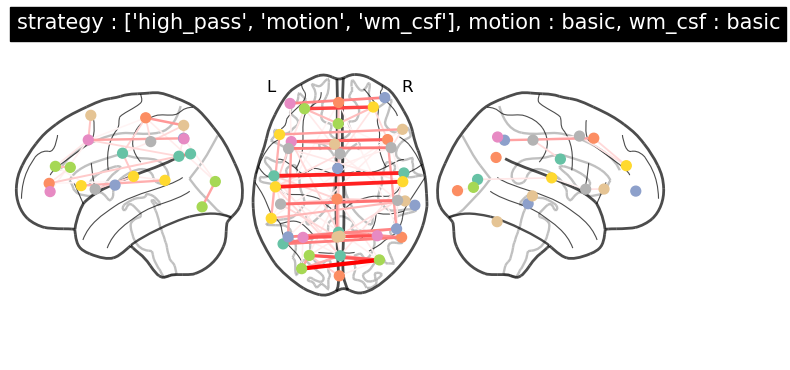

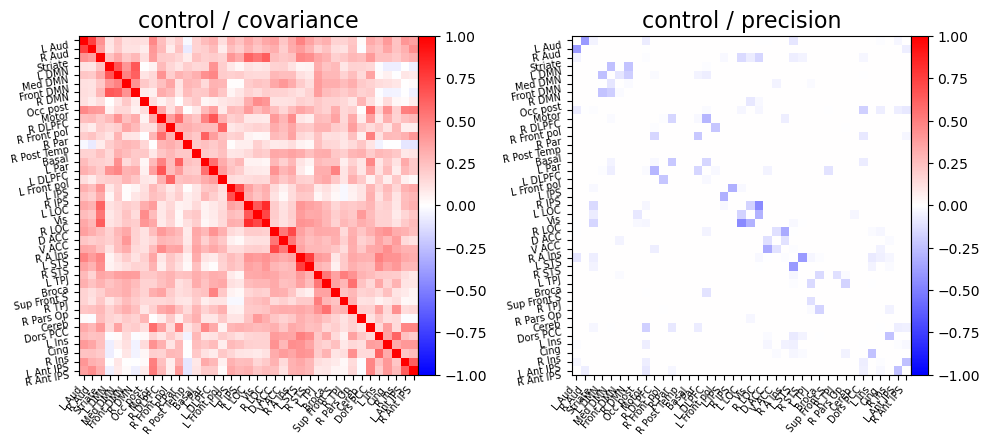

In [38]:
plotting.plot_connectome(
    -control_gsc.precisions_.mean(axis=2),
    atlas.get_coords(),
    edge_threshold="90%",
    title=title,
    display_mode="lzr",
)

# Mean ou pas mean?
plot_matrices(control_gsc.covariances_.mean(axis=2), control_gsc.precisions_.mean(axis=2), "control", atlas.labels)

plotting.show()

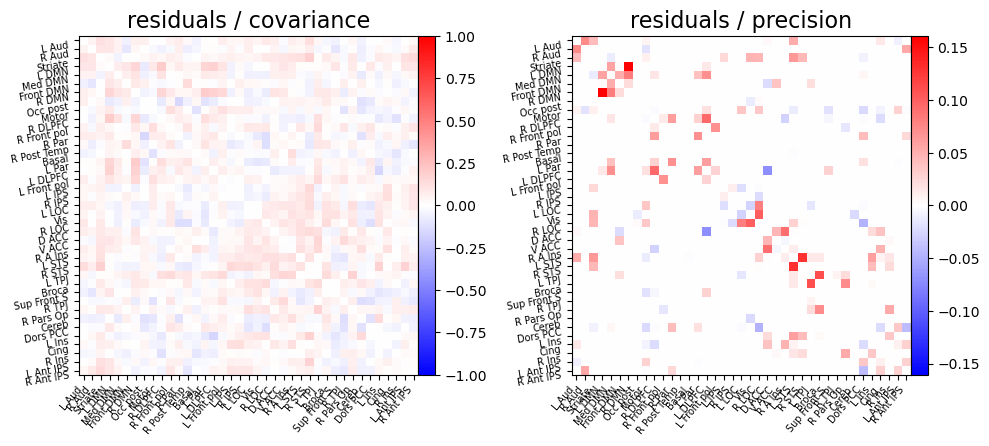

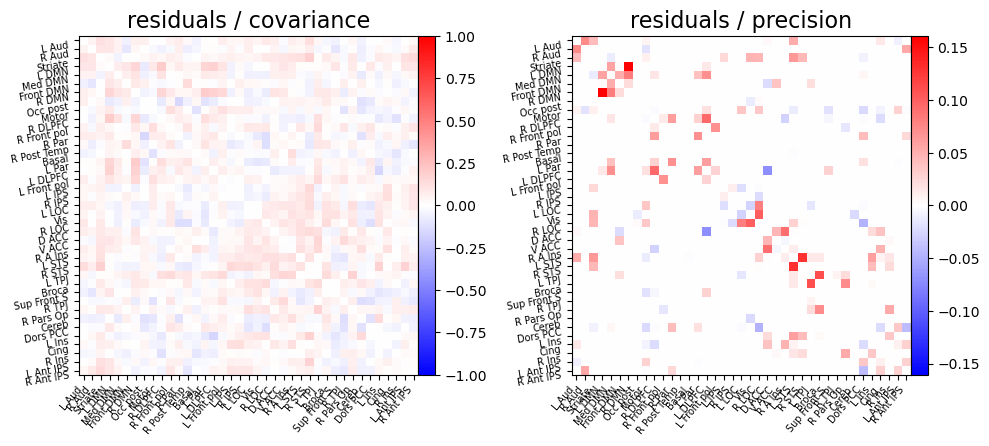

In [14]:

plot_matrices(control_gsc.covariances_.mean(axis=2) - AD_gsc.covariances_.mean(axis=2), -control_gsc.precisions_.mean(axis=2) + AD_gsc.precisions_.mean(axis=2), "residuals", atlas.labels)

In [17]:
len(control_ts)

16